In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, log_loss

In [4]:
# Import cleaned dataframe from EDA notebook. 

df = pd.read_csv("../DataSets/cleaned_df.csv")

pd.set_option('display.max_columns', None)

# Logistic Regression

Classification Report:
               precision    recall  f1-score   support

Normal Weight       0.76      0.61      0.68        57
        Obese       0.73      0.88      0.80       195
   Overweight       0.59      0.43      0.50       116

     accuracy                           0.70       368
    macro avg       0.69      0.64      0.66       368
 weighted avg       0.69      0.70      0.68       368

Log Loss: 0.7517


/Users/gerardogutierrez/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


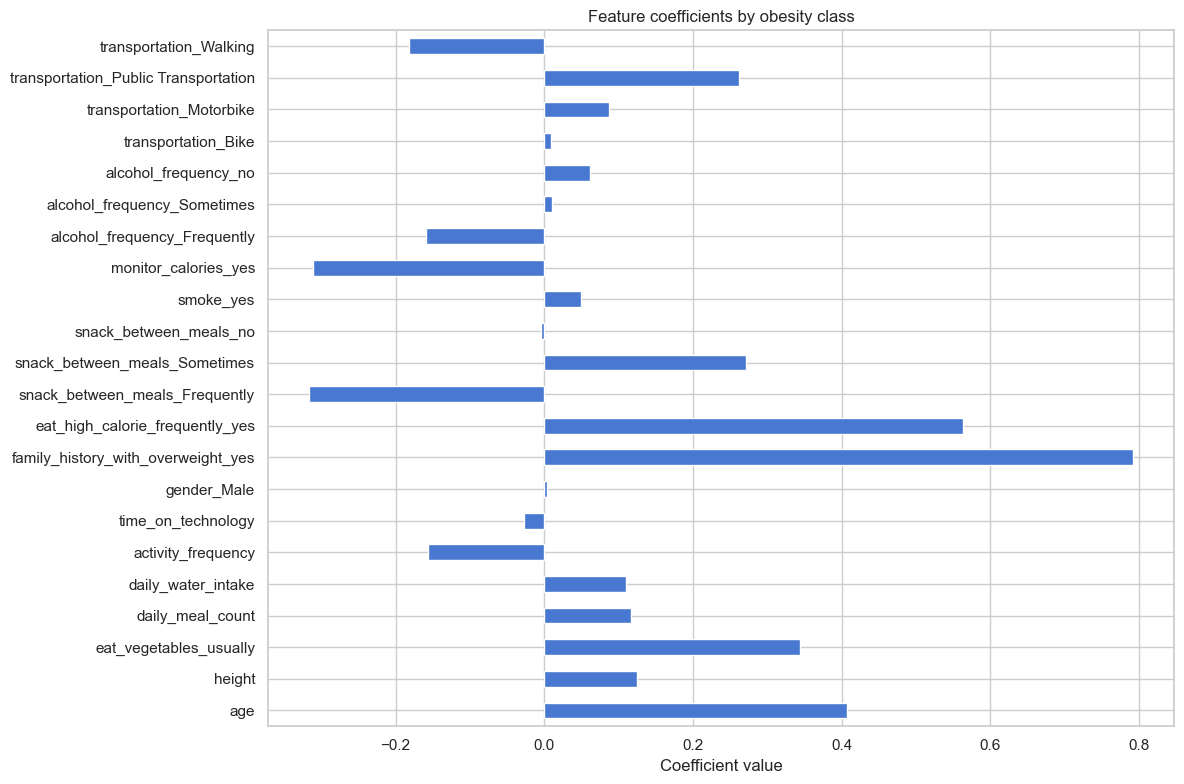


Top predictors for class 'Normal Weight':
Positive: activity_frequency                0.245183
transportation_Walking            0.166825
smoke_yes                         0.123781
monitor_calories_yes              0.062260
snack_between_meals_Frequently    0.057026
Negative: family_history_with_overweight_yes   -0.638061
snack_between_meals_Sometimes        -0.619640
age                                  -0.583488
eat_high_calorie_frequently_yes      -0.345902
snack_between_meals_no               -0.269205

Top predictors for class 'Obese':
Positive: family_history_with_overweight_yes    0.791610
eat_high_calorie_frequently_yes       0.563415
age                                   0.406817
eat_vegetables_usually                0.344273
snack_between_meals_Sometimes         0.270988
Negative: snack_between_meals_Frequently   -0.315697
monitor_calories_yes             -0.310844
transportation_Walking           -0.182472
alcohol_frequency_Frequently     -0.159573
activity_frequency       

In [13]:


# Copy dataframe and group obesity levels
df = df.drop(['bmi', 'obese'], axis=1).copy()

# Group detailed obesity categories into broader groups for calassification
obesity_groups = {
    'Normal Weight': 'Normal Weight',
    'Overweight Level I': 'Overweight',
    'Overweight Level II': 'Overweight',
    'Obesity Type I': 'Obese',
    'Obesity Type II': 'Obese',
    'Obesity Type III': 'Obese'
}
df['obesity_level'] = df['obesity_level'].map(obesity_groups)

#Remove any rows with missing target labels
df = df.dropna(subset=['obesity_level'])

# Separate features (X) and target (y)
X = df.drop('obesity_level', axis=1)
y = df['obesity_level']

# Convert categorical features to dummy variables (excluding target)
# Hot encoding - converts categorical variables into binary values 
# Because logistic regression used for binary classification
# treats inputs as independent variables
X_encoded = pd.get_dummies(X, drop_first=True)

#Dropping all age, height, and weight columns 
for col in ['Age', 'Height', 'Weight']:
    if col in X_encoded.columns:
        X_encoded = X_encoded.drop(col, axis=1)

# Splits dataset into training and testing (80/20)
# Train model on one portion and evaluate with another portion
# prevents overfitting and gives unbiased estiamte or performance
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()   # Standardize features to have mean=0 and std=1
X_train_scaled = scaler.fit_transform(X_train) #Calculates mean and sd -> transforms training data (prevent data leackage)
X_test_scaled = scaler.transform(X_test)  #Calculates mean and sd -> transforms test data (ensure consistency)

# Train multiclass logistic regression model
model = LogisticRegression(
    multi_class='multinomial', #predict one of multiple obesity levels
    solver='lbfgs',  # Suitable for multinomial loss
    max_iter=1000,
    random_state=42
)

model.fit(X_train_scaled, y_train) #fits logistic regression model to training data
# learns relationship between input features and obesity categories
# calculates optimal coefficents

# Predict probabilites for each target class
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Log Loss: {log_loss(y_test, y_prob):.4f}")

# Plot feature coefficients
coefficients = pd.DataFrame(model.coef_.T, index=X_encoded.columns,columns=model.classes_ )
obese_coefs = coefficients['Obese']
obese_coefs.plot.barh(figsize=(12,8))
plt.title("Feature coefficients by obesity class")
plt.xlabel("Coefficient value")
plt.tight_layout()
plt.show()

# Print top predictors for each class
for i, class_name in enumerate(model.classes_):
    class_coef = model.coef_[i]
    coefficients = pd.Series(class_coef, index=X_encoded.columns)
    print(f"\nTop predictors for class '{class_name}':")
    print("Positive:", coefficients.nlargest(5).to_string())
    print("Negative:", coefficients.nsmallest(5).to_string())
    # Accuracy - recall, portion of the total predictions that were correct
    # Precision - How many were actually correct
    # Recall - how many were correctly identified 